In [1]:
# !python -m spacy download nl_core_news_sm

In [2]:
# pip install regex datasets spacy scikit-learn tqdm pickle5 matplotlib torchtext torchcrf torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [3]:
import pandas as pd
import numpy as np
import re

from datasets import Dataset
import spacy
import gensim
import os
from sklearn.metrics import f1_score
from tqdm import tqdm
import pickle
import math
import time
import matplotlib.pyplot as plt

C:\Users\niels\miniconda3\envs\fasttext\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vectors
from torchtext.vocab import GloVe
from torch.optim import Adam
import torch.nn as nn
from TorchCRF import CRF
from torch.cuda.amp import GradScaler, autocast

C:\Users\niels\miniconda3\envs\fasttext\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\niels\miniconda3\envs\fasttext\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [5]:
from loss_functions import compute_class_weights

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
# Load an Excel file into a DataFrame
df = pd.read_excel('manullay_check_partially_matched_titles.xlsx', engine='openpyxl')
# df = pd.read_excel('LCReviewsIntegrated_1962-1994.xlsx', engine='openpyxl')

In [9]:
def remove_extra_spaces(text):
    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [10]:
df['content'] = df['content'].apply(remove_extra_spaces)
df['title1'] = df['title1'].apply(remove_extra_spaces)
df['title4'] = df['title4'].apply(remove_extra_spaces)

In [11]:
def remove_punctuation(input_string):
    # Adding old Dutch quotation marks to the punctuation list
    extended_punctuation = string.punctuation + '„“'
    # Create a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', extended_punctuation)
    # Translate the input string using the translation table
    return input_string.translate(translator)

In [12]:
# First, filter rows where 'manually_removed' is 1 and get unique 'content' values in these rows
content_removed = df[df['manually_removed'] == 1]['content'].unique()

# Now, filter out these 'content' values from the main DataFrame and find unique 'content' not removed
df_clean = df[~df['content'].isin(content_removed)]

## Preprare for training

In [13]:
label_list = ['O', 'I']

In [14]:
def find_sentence_in_text(full_text, sentence):
    start_index = full_text.find(sentence)
    if start_index == -1:
        raise ValueError("Sentence not found in text.")
    end_index = start_index + len(sentence)
    return start_index, end_index


def create_mask_for_sentence(full_text, sentence, nlp, force_lower_case=False):
    # Use the already loaded nlp model to process the text
    doc = nlp(full_text)
    start_index, end_index = find_sentence_in_text(full_text.lower(), sentence.lower())
    if start_index is None:
        return None, None
    if force_lower_case:
        tokens = [token.text.lower() for token in doc]
    else:
        tokens = [token.text for token in doc]
    mask = [0] * len(doc)

    for i, token in enumerate(doc):
        token_end_idx = token.idx + len(token.text)
        if token.idx <= end_index and token_end_idx >= start_index:
            mask[i] = 1

    return tokens, mask


def create_data_set(samples, df, nlp, remove_punc=False, force_lower_case=False):
    data = []
    for sample in tqdm(samples):
        unique_content_df = df[df['content'] == sample]
        masks = []

        if remove_punc:
            review = remove_punctuation(sample)
        else:
            review = sample
        
        for _, row in unique_content_df.iterrows():
            if remove_punc:
                book = remove_punctuation(row['title4'])
            else:
                book = row['title4']
                
            tokens, mask = create_mask_for_sentence(full_text=review, sentence=book, nlp=nlp, force_lower_case=force_lower_case) 
            if mask is not None:
                masks.append(mask)

        if masks:
            combined_mask = np.bitwise_or.reduce(np.array(masks), axis=0)
            data.append({"tokens": tokens, "ner_tags": combined_mask})

    return data

In [15]:
nlp = spacy.load("nl_core_news_sm")

In [16]:
remove_punc = False
force_lower_case = False

In [17]:
train_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/train_dataset.pkl'
val_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/dataset/val_dataset.pkl'

In [18]:
# Function to save dataset to file
def save_dataset(dataset, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure the directory exists
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)

# Function to load dataset from file
def load_dataset(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [19]:
# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the unique samples
samples = df_clean['content'].unique()
np.random.shuffle(samples)

# Calculate the split index
split_idx = int(len(samples) * 0.85)

# Split the samples into training and validation sets
train_samples = samples[:split_idx]
val_samples = samples[split_idx:]

if os.path.exists(train_filename) and os.path.exists(val_filename):
    print("Loading training and validation datasets....")
    train_dataset = load_dataset(train_filename)
    val_dataset = load_dataset(val_filename)
else:
    print("Creating training and validation datasets....")
    # Create dataset
    train_dataset = Dataset.from_list(create_data_set(samples=train_samples, df=df_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    val_dataset = Dataset.from_list(create_data_set(samples=val_samples, df=df_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))

    # Save dataset, so we don't have to create it everytime again
    save_dataset(train_dataset, train_filename)
    save_dataset(val_dataset, val_filename)

print("Done...")

Loading training and validation datasets....
Done...


In [20]:
train_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 10654
})

In [21]:
val_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1881
})

In [22]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format("C:\\Users\\niels\\PycharmProjects\\BookReviewsThesis\\wordembeddings\\cc.nl.300.vec")

vocab = {word: idx for idx, word in enumerate(w2v_model.index_to_key)}
unk_index = len(vocab)  # Index for unknown words

In [23]:
unk_index

2000000

In [24]:
# # Convert Word2Vec embeddings to torch tensor
# pretrained_embeddings = torch.FloatTensor(w2v_model.vectors)

# Convert Word2Vec embeddings to torch tensor and add an extra row for unknown tokens
pretrained_embeddings = torch.FloatTensor(np.vstack((w2v_model.vectors, np.zeros((1, w2v_model.vector_size)))))


In [25]:
# # Specify the path to the manually downloaded GloVe file
# cache_dir = 'C:\\Users\\niels\\PycharmProjects\\BookReviewsThesis\\wordembeddings'

# # Load GloVe embeddings from the specified directory
# # 6B - 39.68% unkown tokens
# # 840B - 24% unkown tokens
# glove = GloVe(name='840B', dim=300, cache=cache_dir)

# # Token to index mapping with fallback for unknown tokens
# vocab = glove.stoi

# unk_index = 0

In [26]:
# Padding function
def pad_sequence(sequence, max_len, pad_value=0):
    return sequence + [pad_value] * (max_len - len(sequence))

# Collate function for DataLoader
def collate_fn(batch):
    max_len = max(len(item['tokens']) for item in batch)
    tokens = [pad_sequence([vocab.get(token, unk_index) for token in item['tokens']], max_len) for item in batch]
    ner_tags = [pad_sequence(item['ner_tags'], max_len) for item in batch]

    # Debugging: Check the range of indices
    tokens_tensor = torch.tensor(tokens)
    ner_tags_tensor = torch.tensor(ner_tags)
    # Debugging: Check the range of indices
    assert tokens_tensor.max().item() < pretrained_embeddings.size(0), f"Found index out of range: {tokens_tensor.max().item()}"
    assert tokens_tensor.min().item() >= 0, f"Found negative index: {tokens_tensor.min().item()}"
    

    
    return torch.tensor(tokens), torch.tensor(ner_tags)




# Optimize DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn, shuffle=False)

In [27]:
# Function to count unknown tokens in the dataset
def count_unknown_tokens(dataset, vocab, unk_index=0):
    unknown_token_count = 0
    total_token_count = 0

    for item in dataset:
        for token in item['tokens']:
            total_token_count += 1
            if vocab.get(token, unk_index) == unk_index:
                unknown_token_count += 1

    return unknown_token_count, total_token_count

# Calculate the number of unknown tokens in the train_dataset
unknown_token_count, total_token_count = count_unknown_tokens(train_dataset, vocab, unk_index)

print(f"Number of unknown tokens: {unknown_token_count}")
print(f"Total number of tokens: {total_token_count}")
print(f"Percentage of unknown tokens: {100 * unknown_token_count / total_token_count:.2f}%")

Number of unknown tokens: 188168
Total number of tokens: 6502228
Percentage of unknown tokens: 2.89%


In [45]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, pretrained_embeddings):
        super(BiLSTMCRF, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(tagset_size)
    
    def forward(self, sentences):
        embeddings = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeddings)
        emissions = self.hidden2tag(lstm_out)
        return emissions
    
    def loss(self, emissions, tags, mask):
        return -self.crf(emissions, tags, mask=mask)
    
    def predict(self, emissions, mask):
        return self.crf.viterbi_decode(emissions, mask=mask)

# Hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
TAGSET_SIZE = 2

# Initialize model
# model = BiLSTMCRF(len(vocab), TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, glove.vectors)
model = BiLSTMCRF(len(vocab), TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, pretrained_embeddings)


# Move the model to the GPU
model.to(device)

BiLSTMCRF(
  (embedding): Embedding(2000001, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=200, out_features=2, bias=True)
  (crf): CRF()
)

In [46]:
def evaluate(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for sentences, tags in dataloader:
            sentences, tags = sentences.to(device), tags.to(device)  # Move data to GPU
            mask = sentences != 0
            mask[:, 0] = 1  # Ensure the first timestep mask is always on
            emissions = model(sentences)
            predictions = model.predict(emissions, mask)
            for i, sentence in enumerate(sentences):
                valid_length = mask[i].sum().item()
                all_predictions.extend(predictions[i][:valid_length])
                all_labels.extend(tags[i][:valid_length].tolist())
    return sum(all_predictions), f1_score(y_true=all_labels, y_pred=all_predictions, average='macro')

In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(model)
print(f'Total number of trainable parameters: {num_parameters}')

Total number of trainable parameters: 322010


In [48]:
# # Custom MoMLoss using the model's CRF loss
# class MoMLoss(torch.nn.Module):
#     def __init__(self, model):
#         super(MoMLoss, self).__init__()
#         self.model = model

#     def forward(self, emissions, tags, mask):
#         # Ensure emissions, tags, and mask have the correct dimensions
#         # emissions: [batch_size, seq_len, num_classes]
#         # tags: [batch_size, seq_len]
#         # mask: [batch_size, seq_len]

#         # Compute class weights
#         flattened_tags = tags.view(-1)
#         weights = compute_class_weights(flattened_tags)

#         # Calculate the CRF loss using the model's loss function
#         loss = self.model.loss(emissions, tags, mask)

#         # Apply weights to the valid positions
#         weighted_loss = loss * weights[flattened_tags].view(tags.size())
#         return weighted_loss.mean()


class MoMLoss(nn.Module):
    def __init__(self, model):
        super(MoMLoss, self).__init__()
        self.model = model

    def forward(self, emissions, tags, mask):
        # Compute class weights
        flattened_tags = tags.view(-1)
        weights = compute_class_weights(flattened_tags)
        
        # Calculate the CRF loss using the model's loss function
        loss = self.model.loss(emissions, tags, mask)  # Shape: [batch_size]

        # Calculate the weights for each sequence in the batch
        sequence_weights = weights[tags]  # Shape: [batch_size, seq_len]

        # Apply the mask to the weights
        sequence_weights = sequence_weights * mask.float()

        # Compute the average weight for each sequence
        sequence_weights = sequence_weights.sum(dim=1) / mask.sum(dim=1).float()

        # Apply the sequence weights to the loss
        weighted_loss = loss * sequence_weights

        # Return the mean of the weighted loss
        return weighted_loss.mean()

In [49]:
# Define your training function
def train(model, dataloader, val_dataloader, epochs=5):
    len_dataloader = len(dataloader)
    optimizer = Adam(model.parameters())
    scaler = GradScaler()  # Mixed precision scaler
    criterion = MoMLoss(model)  # Use the custom MoMLoss with CRF loss

    # History dictionary to store loss and evaluation metrics
    history = {
        "epoch": [],
        "loss": [],
        "eval_f1": [],
        "total_I_pred": []
    }

    # Start the timer
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for sentences, tags in tqdm(dataloader):
            sentences, tags = sentences.to(device), tags.to(device)  # Move data to GPU
            mask = sentences != 0
            mask[:, 0] = 1  # Ensure the first timestep mask is always on

            optimizer.zero_grad()
            with autocast():  # Mixed precision context
                emissions = model(sentences)
                loss = criterion(emissions, tags, mask)  # Use custom MoMLoss with CRF loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            
        I_total_pred, eval_f1 = evaluate(model, val_dataloader)
        avg_loss = total_loss / len_dataloader
        
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}, Eval F1: {eval_f1}, Total I pred: {I_total_pred}')

        # Update history
        history["epoch"].append(epoch + 1)
        history["loss"].append(avg_loss)
        history["eval_f1"].append(eval_f1)
        history["total_I_pred"].append(I_total_pred)
    
    # End the timer
    training_time = time.time() - start_time

    history['total_train_time'] = training_time
    
    print(f'Training completed in: {training_time:.2f} seconds')

    return history

In [50]:
training_history = train(model, train_dataloader, val_dataloader, epochs=20)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:32<00:00,  5.95s/it]


Epoch 1, Loss: 444.83600328639596, Eval F1: 0.6699750520172721, Total I pred: 5182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:22<00:00,  5.88s/it]


Epoch 2, Loss: 171.01879827990504, Eval F1: 0.7573078443477476, Total I pred: 8472


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:24<00:00,  5.89s/it]


Epoch 3, Loss: 145.95187770820664, Eval F1: 0.7850393091844821, Total I pred: 9748


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:30<00:00,  5.93s/it]


Epoch 4, Loss: 134.65002672115486, Eval F1: 0.8042711653936987, Total I pred: 11808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:26<00:00,  5.91s/it]


Epoch 5, Loss: 120.74862088414723, Eval F1: 0.8162174480233273, Total I pred: 12045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:28<00:00,  5.92s/it]


Epoch 6, Loss: 112.32174547846446, Eval F1: 0.820356575070871, Total I pred: 12677


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:29<00:00,  5.92s/it]


Epoch 7, Loss: 104.37546596412888, Eval F1: 0.8137806195976718, Total I pred: 10759


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:28<00:00,  5.92s/it]


Epoch 8, Loss: 97.33656994025864, Eval F1: 0.8108052816762285, Total I pred: 10333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:37<00:00,  5.97s/it]


Epoch 9, Loss: 91.24430710112978, Eval F1: 0.8268670436458345, Total I pred: 11623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:33<00:00,  5.95s/it]


Epoch 10, Loss: 84.92405353477615, Eval F1: 0.8248818132595198, Total I pred: 11423


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:25<00:00,  5.90s/it]


Epoch 11, Loss: 77.93033478788273, Eval F1: 0.8307322310013769, Total I pred: 12887


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:17<00:00,  5.85s/it]


Epoch 12, Loss: 73.77831340264417, Eval F1: 0.8228041586525536, Total I pred: 11546


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:26<00:00,  5.91s/it]


Epoch 13, Loss: 70.01444172430895, Eval F1: 0.8331159939321213, Total I pred: 12582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:24<00:00,  5.89s/it]


Epoch 14, Loss: 66.22917600163443, Eval F1: 0.8324735155691221, Total I pred: 13630


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:36<00:00,  5.97s/it]


Epoch 15, Loss: 63.27314671499287, Eval F1: 0.8312617371181534, Total I pred: 11692


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:30<00:00,  5.93s/it]


Epoch 16, Loss: 59.60503615876158, Eval F1: 0.8352788889408864, Total I pred: 13580


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:17<00:00,  5.86s/it]


Epoch 17, Loss: 56.33952988264804, Eval F1: 0.8292488618954792, Total I pred: 11800


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:21<00:00,  5.88s/it]


Epoch 18, Loss: 53.578691482543945, Eval F1: 0.8321529386643021, Total I pred: 12110


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:17<00:00,  5.85s/it]


Epoch 19, Loss: 51.22646498537349, Eval F1: 0.8363351473349655, Total I pred: 14050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [16:20<00:00,  5.87s/it]


Epoch 20, Loss: 49.033999448764824, Eval F1: 0.8333784603426164, Total I pred: 13312
Training completed in: 20627.66 seconds


In [51]:
training_history

{'epoch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'loss': [444.83600328639596,
  171.01879827990504,
  145.95187770820664,
  134.65002672115486,
  120.74862088414723,
  112.32174547846446,
  104.37546596412888,
  97.33656994025864,
  91.24430710112978,
  84.92405353477615,
  77.93033478788273,
  73.77831340264417,
  70.01444172430895,
  66.22917600163443,
  63.27314671499287,
  59.60503615876158,
  56.33952988264804,
  53.578691482543945,
  51.22646498537349,
  49.033999448764824],
 'eval_f1': [0.6699750520172721,
  0.7573078443477476,
  0.7850393091844821,
  0.8042711653936987,
  0.8162174480233273,
  0.820356575070871,
  0.8137806195976718,
  0.8108052816762285,
  0.8268670436458345,
  0.8248818132595198,
  0.8307322310013769,
  0.8228041586525536,
  0.8331159939321213,
  0.8324735155691221,
  0.8312617371181534,
  0.8352788889408864,
  0.8292488618954792,
  0.8321529386643021,
  0.8363351473349655,
  0.833378460

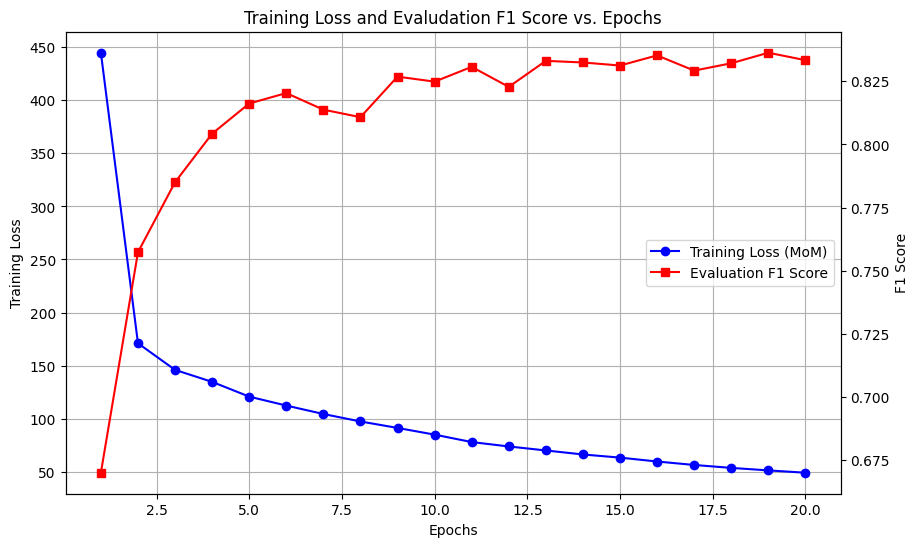

In [52]:
# Create the plot for smoothed training loss
fig, ax1 = plt.subplots(figsize=(10, 6))
line1, = ax1.plot(training_history['epoch'], training_history['loss'], marker='o', color='b', label='Training Loss (MoM)')
ax1.set_title("Training Loss and Evaludation F1 Score vs. Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss")
ax1.grid(True)

# Create secondary y-axis for F1 scores
ax2 = ax1.twinx()
line2, = ax2.plot(training_history['epoch'], training_history['eval_f1'], marker='s', color='r', label='Evaluation F1 Score')
ax2.set_ylabel('F1 Score')

# Combine legends from both axes
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')